In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from functions import q_drydown, exponential_drydown, loss_model

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [2]:
dir_name = f"raraki_2023-11-25_global_95asmax"

# Read data

In [3]:
input_file = rf"/home/raraki/waves/projects/smap-drydown/output/{dir_name}/all_results.csv"
_df = pd.read_csv(input_file)
coord_info_file = "/home/raraki/waves/projects/smap-drydown/data/datarods/coord_info.csv"
coord_info = pd.read_csv(coord_info_file)
df = _df.merge(coord_info, on=['EASE_row_index', 'EASE_column_index'], how='left')
print(f"Number of events: {len(df)}")
df.head()

Number of events: 588194


,Unnamed: 0,EASE_row_index,EASE_column_index,event_start,event_end,time,sm,min_sm,max_sm,pet,...,exp_r_squared,exp_y_opt,q_k,q_q,q_delta_theta,q_r_squared,q_y_opt,id,latitude,longitude
0,0,6,730,2015-07-07,2015-07-11,[1 2 3 4],[0.30713837 0.28085642 0.24799749 0.22460759],0.088373,0.318546,1.442777,...,0.971327,"[0.30721188076022926, 0.2729472772819034, 0.24...",0.097634,7.248424e-14,1.000000,0.949016,"[0.29607309083610084, 0.27360024792220194, 0.2...",6514,74.71601,92.80083
1,1,6,730,2015-09-04,2015-09-09,[1 2 3 4 5],[0.31340383 0.2997787 0.29239778 0.28315416 0...,0.088373,0.318546,0.564329,...,0.934791,"[0.3143936336489097, 0.30014785762607954, 0.28...",0.042653,4.914108e-15,1.000000,0.937212,"[0.3087283792729129, 0.2989108247958259, 0.289...",6514,74.71601,92.80083
2,2,6,730,2018-08-14,2018-08-28,[ 2 3 4 5 6 7 8 9 10 11 12 13 14],[0.31223514 0.29456268 0.2779323 0.2713341 0...,0.088373,0.318546,0.861008,...,0.578249,"[0.29981222834147464, 0.29402804842083086, 0.2...",0.079208,1.063666e+01,1.000000,0.594935,"[0.29743873412168303, 0.2917893984623552, 0.28...",6514,74.71601,92.80083
3,0,6,731,2015-07-07,2015-07-12,[1 2 3 4 5],[0.29125712 0.26151791 0.22887894 0.23347034 0...,0.086197,0.313482,1.390767,...,0.958683,"[0.2919720832552387, 0.25676322377973104, 0.23...",0.157485,2.233977e+00,1.000000,0.913024,"[0.2830171775741852, 0.26038232314236803, 0.24...",6515,74.71601,93.17427
4,1,6,731,2015-09-04,2015-09-10,[2 3 4 5 6],[0.28169658 0.2896581 0.26309461 0.24856516 0...,0.086197,0.313482,0.578359,...,0.648419,"[0.2860845033697074, 0.2752390328406541, 0.266...",0.067436,2.643255e+00,0.995962,0.652026,"[0.2867481281787417, 0.2764784662039014, 0.267...",6515,74.71601,93.17427


In [4]:
def calculate_sm_range(row):
    input_string = row.sm

    # Processing the string
    input_string = input_string.replace('\n', ' np.nan')
    input_string = input_string.replace(' nan', ' np.nan')
    input_string = input_string.strip('[]')

    # Converting to numpy array and handling np.nan
    sm = np.array([float(value) if value != 'np.nan' else np.nan for value in input_string.split()])

    # Calculating sm_range
    sm_range = (np.nanmax(sm) - np.nanmin(sm)) / (row.max_sm - row.min_sm) if row.max_sm != row.min_sm else np.nan
    return sm_range

# Applying the function to each row and creating a new column 'sm_range'
df['sm_range'] = df.apply(calculate_sm_range, axis=1)

In [17]:
# print(df[df["q_r_squared"]>df["exp_r_squared"]].index)
# print(df[(df["q_r_squared"]>0.7) & (df["q_k"]>10) & (df["sm_range"]>0.5)].index)
print(df[(df["q_q"] < 0.5)& (df["sm_range"]>0.3)].index)

Index([     0,     53,     75,     82,     99,    109,    111,    114,    116,
          117,
       ...
       588147, 588150, 588152, 588158, 588159, 588162, 588170, 588181, 588185,
       588188],
      dtype='int64', length=89507)


In [88]:
event_id = 588185

In [89]:
event = df.loc[event_id]

In [90]:
event.sm_range

0.36753378282151006

In [91]:
# Your input string
input_string =event.sm

# Replace '\n' with ' ' (space) to ensure all numbers are separated by spaces
input_string = input_string.replace('\n', ' np.nan')

# Replace ' nan' with ' np.nan' (with a space before np.nan) to ensure it's a valid NumPy nan value
input_string = input_string.replace(' nan', ' np.nan')

# Remove the square brackets at the beginning and end of the string
input_string = input_string.strip('[]')

# Convert the modified string to a NumPy array
sm = np.array([float(value) if value != 'np.nan' else np.nan for value in input_string.split()])
sm

array([0.27411696, 0.26087719, 0.26928109, 0.18594747])

In [92]:
# Your input string

# Remove the square brackets and split the string into individual values
values = event.time.strip('[]').split()

# Convert the values to integers and create a NumPy array
t_d = np.array([int(value) for value in values])
t_d

array([0, 1, 2, 4])

In [93]:
import ast
def string_to_numpy_array(string):
    try:
        # Use ast.literal_eval to safely evaluate the string as a list
        return np.array(ast.literal_eval(string))
    except (SyntaxError, ValueError):
        return np.nan  # Return NaN if the string cannot be converted


In [94]:
n_days = (pd.to_datetime(event.event_end) - pd.to_datetime(event.event_start)).days
n_days

4

In [95]:
# Define variables 
theta = np.arange(0, 1, 0.01)
t = np.arange(0, n_days+1, 0.1)
# t_d = np.array([float(value) if value != 'np.nan' else np.nan for value in event.time.split()])
# t_h = pd.date_range(start=event.event_start, end=event.event_end, freq="H")

# Define parameters
k= event.q_k
q0 = 1
q = event.q_q
delta_theta = event.q_delta_theta
# q2 = 0.7
min_sm = event.min_sm
max_sm = event.max_sm

_exp_y_opt = np.array(ast.literal_eval(event.exp_y_opt)) # df['exp_y_opt'].apply(string_to_numpy_array)
exp_y_opt = (_exp_y_opt - min_sm)/(max_sm - min_sm)
_q_y_opt = np.array(ast.literal_eval(event.q_y_opt)) # df['q_y_opt'].apply(string_to_numpy_array)
q_y_opt = (_q_y_opt - min_sm)/(max_sm - min_sm)

exp_delta_theta = event.exp_delta_theta
theta_w = event.exp_theta_w
tau = event.exp_tau

norm_sm =  (sm-min_sm)/(max_sm-min_sm)


In [96]:
t_d

array([0, 1, 2, 4])

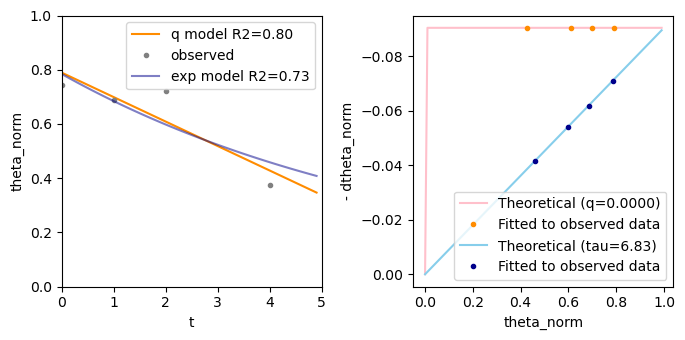

In [97]:
fig = plt.figure(figsize=(7,3.5))

# Calculate & plot the drawdown
ax1 = fig.add_subplot(1,2,1)

# Exponential decay
# ax2.plot(t, q_model(t=t, k=k), '.', label=f'q={q0}')

q_r2 = event.q_r_squared
exp_r2 = event.exp_r_squared

# Calculated drydown model
# ax2.plot(t, q_y_opt, '.', label=f'q={q1}')
ax1.plot(t, q_drydown(t=t, k=k, q=q, delta_theta=delta_theta), label=f'q model R2={q_r2:.2f}', color='darkorange')
# ax1.plot(t_d, q_y_opt,  '.', color='darkorange')
ax1.plot(t_d, norm_sm[~np.isnan(norm_sm)],  '.', color='gray', label='observed')
_exp = exponential_drydown(t, exp_delta_theta, theta_w, tau)
ax1.plot(t, (_exp-min_sm)/(max_sm - min_sm), label=f'exp model R2={exp_r2:.2f}', color='darkblue', alpha=0.5)
# ax1.plot(t_d, exp_y_opt, '.',  color='darkblue', alpha=0.5)
ax1.set_xlabel("t")
ax1.set_ylabel("theta_norm")
ax1.set_xlim(t_d[0], t_d[-1]+1)
ax1.set_ylim(0, 1)
ax1.legend()
# ax2.set_ylim([0., 1])

# # Calculate & plot d_theta
d_theta = loss_model(theta, q, k, theta_wp=0., theta_star=1.)
d_theta_obs = loss_model(q_y_opt, q, k, theta_wp=0., theta_star=1.)
d_theta_exp = loss_model(theta, q=1, k=k, theta_wp=0., theta_star=1.)
d_theta_obs_exp = loss_model(exp_y_opt, q=1, k=k, theta_wp=0., theta_star=1.)

ax2 = fig.add_subplot(1,2,2)
ax2.plot(theta, d_theta, label=f'Theoretical (q={q:.4f})', color='pink')
ax2.plot(q_y_opt, d_theta_obs, '.', label=f'Fitted to observed data', color='darkorange')
ax2.plot(theta, loss_model(theta, q=1, k=k), label=f'Theoretical (tau={tau:.2f})', color='skyblue')
ax2.plot(exp_y_opt, d_theta_obs_exp, '.', label=f'Fitted to observed data', color='darkblue')
ax2.set_xlabel("theta_norm")
ax2.set_ylabel("- dtheta_norm")
ax2.invert_yaxis()
ax2.legend()

fig.tight_layout()

In [57]:
def calc_loss_sigmoid(theta, s50, k, Emax, theta_wp=0.):
    
    d_theta = (Emax + theta_wp) / (1 + np.exp(-k * (theta - s50)))
    
    return d_theta * -1

In [584]:
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize

# The differential equation dy/dt = f(y, a, b)
def loss_sigmoid(t, theta, s50, k, Emax, theta_wp=0.):
    d_theta = -1 * (Emax + theta_wp) / (1 + np.exp(-k * (theta - s50)))
    return d_theta

# Function to solve the DE with given parameters and return y at the time points
def solve_de(parameters):
    s50, k, Emax = parameters
    sol = solve_ivp(lambda t, theta: loss_sigmoid(t, theta, s50, k, Emax), [t_obs[0], t_obs[-1]], [y_init], t_eval=t_obs, vectorized=True)
    return sol.y.ravel()

# The objective function to minimize (sum of squared errors)
def objective_function(parameters):
    y_model = solve_de(parameters)
    error = y_obs - y_model
    return np.sum(error**2)

# Observed time series data
t_obs = t_d
y_obs = norm_sm[~np.isnan(norm_sm)]
y_init = y_obs[0]  # Initial condition (assuming that the first observed data point is the initial condition)

# Initial guess for parameters s50, k, Emax
initial_guess = [0.5, 10, 1.0]

# Perform the optimization
result = minimize(objective_function, initial_guess, method='L-BFGS-B')  # You can choose a different method if needed

# The result contains the optimized parameters
s50_best, k_best, Emax_best = result.x
print(f"Best parameters: s50 = {s50_best}, k = {k_best}, Emax = {Emax_best}")


Best parameters: s50 = 0.8695114314408875, k = 134.69752173181604, Emax = 133.37348381062898


In [381]:
def loss_sigmoid2(theta, s50, k, Emax, theta_wp=0.):
    d_theta = -1 * (Emax + theta_wp) / (1 + np.exp(-k * (theta - s50)))
    return d_theta

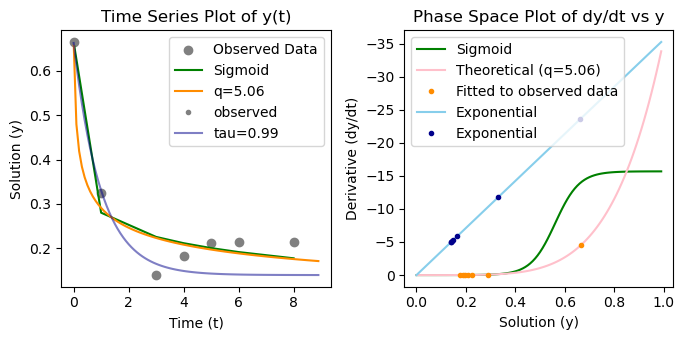

In [382]:
import matplotlib.pyplot as plt

# Assuming you have the a_best and b_best from the optimization step
# Re-compute the model solution with the best-fit parameters
best_solution = solve_ivp(lambda t, theta: loss_sigmoid(t, theta, s50_best, k_best, Emax_best), [t_obs[0], t_obs[-1]], [y_init], t_eval=t_obs)

# Plotting t vs y (The observed data and the model prediction)
fig = plt.figure(figsize=(7,3.5))

# Calculate & plot the drawdown
ax1 = fig.add_subplot(1,2,1)

# Observed data
ax1.scatter(t_obs, y_obs, color='grey', label='Observed Data')
# Model prediction
ax1.plot(best_solution.t, best_solution.y[0], color='green', label='Sigmoid')
ax1.plot(t, q_drydown(t=t, k=k, q=q, delta_theta=delta_theta), label=f'q={q:.2f}', color='darkorange')
# ax1.plot(t_d, q_y_opt,  '.', color='darkorange')
ax1.plot(t_d, norm_sm[~np.isnan(norm_sm)],  '.', color='gray', label='observed')
_exp = exponential_drydown(t, exp_delta_theta, theta_w, tau)
ax1.plot(t, (_exp-min_sm)/(max_sm - min_sm), label=f'tau={tau:.2f}', color='darkblue', alpha=0.5)

ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Solution (y)')
ax1.set_title('Time Series Plot of y(t)')
ax1.legend()


# To plot y vs dy/dt, we need to compute dy/dt for the model prediction

ax2 = fig.add_subplot(1,2,2)

# Plot the derivative against the solution
ax2.plot(theta, loss_sigmoid2(theta, s50_best, k_best, Emax_best), color='green', label='Sigmoid')
ax2.plot(theta, d_theta, label=f'Theoretical (q={q:.2f})', color='pink')
ax2.plot(q_y_opt, d_theta_obs, '.', label=f'Fitted to observed data', color='darkorange')
ax2.plot(theta, loss_model(theta, q=1, k=k), label=f'Exponential', color='skyblue')
ax2.plot(exp_y_opt, d_theta_obs_exp, '.', label=f'Exponential', color='darkblue')
ax2.set_xlabel('Solution (y)')
ax2.set_ylabel('Derivative (dy/dt)')
ax2.set_title('Phase Space Plot of dy/dt vs y')
ax2.legend()
ax2.invert_yaxis()
fig.tight_layout()


In [307]:
dydt_sample = (0.525-0.46)/1
dydt_sample

0.065

# Denormalize

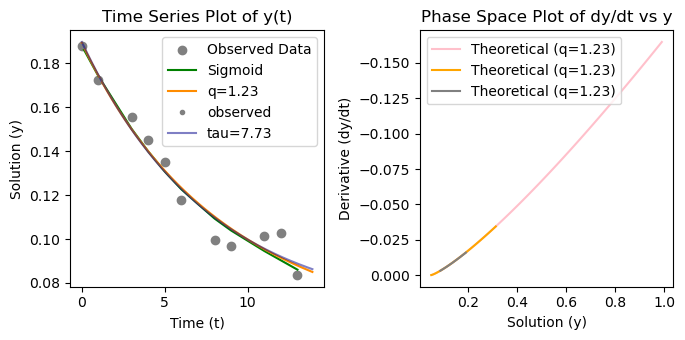

In [244]:
import matplotlib.pyplot as plt

# Plotting t vs y (The observed data and the model prediction)
fig = plt.figure(figsize=(7,3.5))

# Calculate & plot the drawdown
ax1 = fig.add_subplot(1,2,1)


y_denorm = y_obs * (max_sm - min_sm) + min_sm 
d_theta_q_denorm = q_drydown(t=t, k=k, q=q, delta_theta=delta_theta) * (max_sm - min_sm) + min_sm
# Observed data
ax1.scatter(t_obs, y_denorm, color='grey', label='Observed Data')
# Model prediction
ax1.plot(best_solution.t, best_solution.y[0] * (max_sm - min_sm) + min_sm, color='green', label='Sigmoid')
ax1.plot(t, d_theta_q_denorm, label=f'q={q:.2f}', color='darkorange')
# ax1.plot(t_d, q_y_opt,  '.', color='darkorange')
ax1.plot(t_d, norm_sm[~np.isnan(norm_sm)] * (max_sm - min_sm) + min_sm,  '.', color='gray', label='observed')
_exp = exponential_drydown(t, exp_delta_theta , theta_w, tau)
ax1.plot(t, _exp, label=f'tau={tau:.2f}', color='darkblue', alpha=0.5)

ax1.set_xlabel('Time (t)')
ax1.set_ylabel('Solution (y)')
ax1.set_title('Time Series Plot of y(t)')
ax1.legend()


# To plot y vs dy/dt, we need to compute dy/dt for the model prediction

diff_q = np.diff(d_theta_q_denorm)
dt = np.diff(t)
ax2 = fig.add_subplot(1,2,2)
k_denorm = k * (max_sm - min_sm)
theta_denorm = theta  * (max_sm - min_sm) + min_sm
# Plot the derivative against the solution
# ax2.plot(theta, loss_sigmoid2(theta, s50_best, k_best, Emax_best), color='green', label='Sigmoid')
ax2.plot(theta, loss_model(theta, q=q, k=k_denorm, theta_star=max_sm, theta_wp =min_sm), label=f'Theoretical (q={q:.2f})', color='pink')
ax2.plot(theta_denorm, loss_model(theta_denorm, q=q, k=k_denorm, theta_star=max_sm, theta_wp =min_sm), label=f'Theoretical (q={q:.2f})', color='orange')
ax2.plot(d_theta_q[:-1], diff_q/dt, label=f'Theoretical (q={q:.2f})', color='grey')
# ax2.plot(q_y_opt, d_theta_obs, '.', label=f'Fitted to observed data', color='darkorange')
# ax2.plot(theta, loss_model(theta, q=1, k=k_denorm, theta_star=max_sm, theta_wp =min_sm), label=f'Exponential', color='skyblue')
# ax2.plot(exp_y_opt, d_theta_obs_exp, '.', label=f'Exponential', color='darkblue')
ax2.set_xlabel('Solution (y)')
ax2.set_ylabel('Derivative (dy/dt)')
ax2.set_title('Phase Space Plot of dy/dt vs y')
ax2.legend()
ax2.invert_yaxis()
fig.tight_layout()


In [202]:
dydt_sample = (0.19-0.137)/5
dydt_sample

0.010599999999999998

In [229]:
len(t)

140

In [232]:
len(d_theta_q)

140

In [234]:
len(diff_q)

139

In [239]:
d_theta_q

array([0.18938247, 0.1877964 , 0.18623217, 0.18468942, 0.18316779,
       0.18166696, 0.18018657, 0.1787263 , 0.17728583, 0.17586484,
       0.17446302, 0.17308005, 0.17171564, 0.1703695 , 0.16904133,
       0.16773085, 0.16643778, 0.16516185, 0.16390279, 0.16266033,
       0.16143421, 0.16022419, 0.15903   , 0.15785141, 0.15668817,
       0.15554004, 0.1544068 , 0.15328821, 0.15218405, 0.1510941 ,
       0.15001814, 0.14895596, 0.14790736, 0.14687211, 0.14585003,
       0.14484092, 0.14384457, 0.14286081, 0.14188943, 0.14093026,
       0.13998311, 0.13904781, 0.13812417, 0.13721204, 0.13631123,
       0.13542158, 0.13454293, 0.13367511, 0.13281797, 0.13197136,
       0.13113511, 0.13030908, 0.12949312, 0.12868708, 0.12789083,
       0.12710422, 0.12632711, 0.12555936, 0.12480085, 0.12405144,
       0.12331101, 0.12257941, 0.12185654, 0.12114226, 0.12043646,
       0.11973901, 0.11904981, 0.11836872, 0.11769565, 0.11703047,
       0.11637308, 0.11572337, 0.11508124, 0.11444657, 0.11381

In [240]:
t

array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ,
        1.1,  1.2,  1.3,  1.4,  1.5,  1.6,  1.7,  1.8,  1.9,  2. ,  2.1,
        2.2,  2.3,  2.4,  2.5,  2.6,  2.7,  2.8,  2.9,  3. ,  3.1,  3.2,
        3.3,  3.4,  3.5,  3.6,  3.7,  3.8,  3.9,  4. ,  4.1,  4.2,  4.3,
        4.4,  4.5,  4.6,  4.7,  4.8,  4.9,  5. ,  5.1,  5.2,  5.3,  5.4,
        5.5,  5.6,  5.7,  5.8,  5.9,  6. ,  6.1,  6.2,  6.3,  6.4,  6.5,
        6.6,  6.7,  6.8,  6.9,  7. ,  7.1,  7.2,  7.3,  7.4,  7.5,  7.6,
        7.7,  7.8,  7.9,  8. ,  8.1,  8.2,  8.3,  8.4,  8.5,  8.6,  8.7,
        8.8,  8.9,  9. ,  9.1,  9.2,  9.3,  9.4,  9.5,  9.6,  9.7,  9.8,
        9.9, 10. , 10.1, 10.2, 10.3, 10.4, 10.5, 10.6, 10.7, 10.8, 10.9,
       11. , 11.1, 11.2, 11.3, 11.4, 11.5, 11.6, 11.7, 11.8, 11.9, 12. ,
       12.1, 12.2, 12.3, 12.4, 12.5, 12.6, 12.7, 12.8, 12.9, 13. , 13.1,
       13.2, 13.3, 13.4, 13.5, 13.6, 13.7, 13.8, 13.9])